AirBnB Project
---



##Body

###Imports

In [0]:
%matplotlib inline

!pip install category_encoders
!pip install bayesian-optimization

import numpy as np
import gzip
import pandas as pd
import pandas_profiling
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.compose import ColumnTransformer
import category_encoders as ce
import datetime as dt
from datetime import datetime
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import pickle

###Dataframe creation

In [0]:
detailed_listing = 'http://data.insideairbnb.com/united-states/ca/los-angeles/2019-12-05/data/listings.csv.gz'

det_list = pd.read_csv(detailed_listing, compression='gzip', 
                       error_bad_lines=False, warn_bad_lines=False)

print(det_list.shape)
det_list.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(40125, 106)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,109,https://www.airbnb.com/rooms/109,20191205175409,2019-12-06,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...","*** Unit upgraded with new bamboo flooring, br...","*** Unit upgraded with new bamboo flooring, br...",none,NaN,NaN,NaN,NaN,NaN,Camelot NEW RESIDENTS’ GENERAL INFORMATION F...,NaN,NaN,https://a0.muscache.com/im/pictures/4321499/1d...,NaN,521,https://www.airbnb.com/users/show/521,Paolo,2008-06-27,"San Francisco, California, United States",Search for me on the Internet with the keyword...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/521/profile_p...,https://a0.muscache.com/im/users/521/profile_p...,Culver City,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Culver City, CA, United States",Culver City,Culver City,...,$25.00,30,730,30,30,730,730,30.0,730.0,10 months ago,t,0,0,0,248,2019-12-06,2,0,2011-08-15,2016-05-15,80.0,10.0,10.0,6.0,8.0,10.0,8.0,f,NaN,"{""Culver City"","" CA""}",f,f,strict_14_with_grace_period,t,f,1,1,0,0,0.02
1,344,https://www.airbnb.com/rooms/344,20191205175409,2019-12-06,Family perfect;Pool;Near Studios!,This home is perfect for families; aspiring ch...,"Cheerful & comfortable; near studios, amusemen...",This home is perfect for families; aspiring ch...,none,Quiet-yet-close to all the fun in LA! Hollywoo...,"One dog may be on premises, friendly and cared...",Short drive to subway and elevated trains runn...,"Pool, patio and self-contained main house all ...",Host and caretaker may be available throughout...,Host asks that guests refrain from partying lo...,NaN,NaN,https://a0.muscache.com/im/pictures/cc4b724d-d...,NaN,767,https://www.airbnb.com/users/show/767,Melissa,2008-07-11,"Burbank, California, United States","Single mother, CEO and Owner of an internation...",within a few hours,100%,NaN,f,https://a0.muscache.com/im/users/767/profile_p...,https://a0.muscache.com/im/users/767/profile_p...,Burbank,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'kba', ...",t,t,"Burbank, CA, United States",Burbank,Burbank,...,$0.00,2,14,2,2,14,14,2.0,14.0,2 months ago,t,0,0,0,62,2019-12-06,8,2,2016-06-14,2019-10-19,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,t,f,flexible,f,f,1,1,0,0,0.19
2,2708,https://www.airbnb.com/rooms/2708,20191205175409,2019-12-06,Mirrored Mini-Suite with Fireplace - W. Hollywood,Our best memory foam pillows you'll ever sleep...,Flickering fireplace. Blendtec® Designer 625 ...,Our best memory foam pillows you'll ever sleep...,none,We are minutes away from the Mentor Language I...,Blendtec® Designer 625 

In [0]:
calendar_url = 'http://data.insideairbnb.com/united-states/ca/los-angeles/2019-12-05/data/calendar.csv.gz'

calendar_df = pd.read_csv(calendar_url, compression='gzip', 
                          warn_bad_lines=False, error_bad_lines=False)

print(calendar_df.shape)
calendar_df.head()

(14670849, 7)


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,46858,2019-12-06,f,$300.00,$300.00,3.0,30.0
1,130915,2019-12-06,f,$90.00,$90.00,1.0,730.0
2,130915,2019-12-07,f,$90.00,$90.00,1.0,730.0
3,130915,2019-12-08,f,$90.00,$90.00,1.0,730.0
4,130915,2019-12-09,f,$90.00,$90.00,1.0,730.0


In [0]:
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

calendar_df['weekday'] = calendar_df['date'].dt.dayofweek

calendar_df['is_weekend'] = np.where(calendar_df['weekday']>=4, 1, 0)

calendar_df['month'] = calendar_df['date'].dt.month

calendar_df['price'] = calendar_df['price'].str.replace('$','')
calendar_df['price'] = calendar_df['price'].str.replace(',','')
calendar_df['price'] = calendar_df['price'].replace('',np.nan)

calendar_df['price'] = calendar_df['price'].astype(float)

calendar_df = calendar_df[['listing_id', 'price', 'month', 'weekday', 'is_weekend']]

calendar_df.head()

,listing_id,price,month,weekday,is_weekend
0,46858,300.0,12,4,1
1,130915,90.0,12,4,1
2,130915,90.0,12,5,1
3,130915,90.0,12,6,1
4,130915,90.0,12,0,0


In [0]:
# list(summary_list.columns)

In [0]:
# list(det_list.columns)

In [0]:
#pandas_profiling.ProfileReport(det_list)

In [0]:
cols = ['id', 'cleaning_fee', 'bathrooms','bedrooms','longitude','latitude','guests_included',
        'zipcode','property_type','accommodates','beds', 'room_type']

merged_calendar_detailed = pd.merge(det_list[cols], 
                                    calendar_df, how='left', 
                                    left_on='id', right_on='listing_id')

del det_list
del calendar_df

print(merged_calendar_detailed.shape)
merged_calendar_detailed.head()

(14647852, 17)


,id,cleaning_fee,bathrooms,bedrooms,longitude,latitude,guests_included,zipcode,property_type,accommodates,beds,room_type,listing_id,price,month,weekday,is_weekend
0,109,$240.00,2.0,2.0,-118.38494,33.98209,3,90230,Condominium,6,3.0,Entire home/apt,109,115.0,12,4,1
1,109,$240.00,2.0,2.0,-118.38494,33.98209,3,90230,Condominium,6,3.0,Entire home/apt,109,115.0,12,5,1
2,109,$240.00,2.0,2.0,-118.38494,33.98209,3,90230,Condominium,6,3.0,Entire home/apt,109,115.0,12,6,1
3,109,$240.00,2.0,2.0,-118.38494,33.98209,3,90230,Condominium,6,3.0,Entire home/apt,109,115.0,12,0,0
4,109,$240.00,2.0,2.0,-118.38494,33.98209,3,90230,Condominium,6,3.0,Entire home/apt,109,115.0,12,1,0


In [0]:
merged_calendar_detailed['zipcode'].value_counts()[:100].sum()

9640512

In [0]:
train['property_type'].value_counts()

House                     5119955
Apartment                 5067717
Condominium                881956
Guesthouse                 786047
Guest suite                555846
Townhouse                  456666
Villa                      393137
Bungalow                   392450
Loft                       299370
Serviced apartment         100393
Hostel                      85787
Boutique hotel              83955
Cottage                     66805
Camper/RV                   55848
Bed and breakfast           53294
Aparthotel                  52203
Other                       40156
Tiny house                  34315
Hotel                       24457
Cabin                       23728
Farm stay                   12045
Castle                       8395
Boat                         7301
Earth house                  6571
Dome house                   5111
Tent                         4746
Treehouse                    4383
Chalet                       4380
Barn                         3286
Yurt          

In [0]:
train = merged_calendar_detailed.drop(columns= ['listing_id','id'])

train = train[(train['price'].isna() == False) & (train['price']<10000)]

train['beds'] = train['beds'].fillna(train['beds'].mode()[0]).astype(int)
train['bathrooms'] = train['bathrooms'].fillna(train['bathrooms'].median()).astype(int)
train['bedrooms'] = train['bedrooms'].fillna(train['bedrooms'].median()).astype(int)

train['zipcode'] = train['zipcode'].str.strip()
train['zipcode'] = train['zipcode'].str.replace('ca','')
train['zipcode'] = train['zipcode'].str.replace('Ca','')
train['zipcode'] = train['zipcode'].str.replace('CA','')
train['zipcode'] = train['zipcode'].str.replace(' ', '')
train['zipcode'] = train['zipcode'].str.replace('139SValenciaAve,Glendora.', '')
train['zipcode'] = train['zipcode'].str[:5]
train['zipcode'] = train['zipcode'].replace('',np.nan)

top_100_zipcodes = list(train['zipcode'].value_counts()[:100].index)
train['zipcode_recode'] = np.where(train['zipcode'].isin(top_100_zipcodes),
                                         train['zipcode'], 'other')

top_10_clean_fees = list(train['cleaning_fee'].value_counts()[:10].index)
train['cleaning_fee_recoded'] = np.where(train['cleaning_fee'].isin(top_10_clean_fees),
                                         train['cleaning_fee'], '>$150')

top_15_property_types = list(train['property_type'].value_counts()[:15].index)
train['property_type_recoded'] = np.where(train['property_type'].isin(top_15_property_types),
                                  train['property_type'], 'other')

train.head()

,cleaning_fee,bathrooms,bedrooms,longitude,latitude,guests_included,zipcode,property_type,accommodates,beds,room_type,price,month,weekday,is_weekend,zipcode_recode,cleaning_fee_recoded,property_type_recoded
0,$240.00,2,2,-118.38494,33.98209,3,90230,Condominium,6,3,Entire home/apt,115.0,12,4,1,90230,>$150,Condominium
1,$240.00,2,2,-118.38494,33.98209,3,90230,Condominium,6,3,Entire home/apt,115.0,12,5,1,90230,>$150,Condominium
2,$240.00,2,2,-118.38494,33.98209,3,90230,Condominium,6,3,Entire home/apt,115.0,12,6,1,90230,>$150,Condominium
3,$240.00,2,2,-118.38494,33.98209,3,90230,Condominium,6,3,Entire home/apt,115.0,12,0,0,90230,>$150,Condominium
4,$240.00,2,2,-118.38494,33.98209,3,90230,Condominium,6,3,Entire home/apt,115.0,12,1,0,90230,>$150,Condominium


In [0]:
# train.to_csv('final_merged_cleaned.csv')

###Checkpoint

Dataframe saved and can be loaded

In [0]:
# train = pd.read_csv('final_merged_cleaned.csv.gz', compression = 'gzip', index_col=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


next will do a linear regression model for a baseline

In [0]:
# Features we want
train = train.drop(columns=['zipcode','cleaning_fee', 'property_type'])

categorical_features = list(train.select_dtypes(exclude= 'number').columns)

numeric_features = list(train.select_dtypes(include= 'number').columns)

categorical_features

['room_type',
 'zipcode_recode',
 'cleaning_fee_recoded',
 'property_type_recoded']

In [0]:
# categorical_counts = train.select_dtypes(exclude='number').nunique().sort_values()
categorical_counts = []
categorical_counts.append(train[categorical_features].nunique().sort_values())
high_cardi_cols = []
low_cardi_cols = []
for i in categorical_features:
    if train[i].nunique() > 100:
        high_cardi_cols.append(i)
    else:
        low_cardi_cols.append(i)

print(categorical_counts, high_cardi_cols, low_cardi_cols)

[room_type                  4
cleaning_fee_recoded      11
property_type_recoded     16
zipcode_recode           101
dtype: int64] ['zipcode_recode'] ['room_type', 'cleaning_fee_recoded', 'property_type_recoded']


In [0]:
ct = ColumnTransformer([("oe", ce.OrdinalEncoder(), high_cardi_cols),
                        ("ohe", ce.OneHotEncoder(use_cat_names=True), low_cardi_cols)])

In [0]:
# We'll impute missing values using the median for numeric columns and the most
# common value for string columns.

from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

train = DataFrameImputer().fit_transform(train)

In [0]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for feature in categorical_features:
    train[feature] = label_encoder.fit_transform(train[feature])

train.head()

,bathrooms,bedrooms,longitude,latitude,guests_included,accommodates,beds,room_type,price,month,weekday,is_weekend,zipcode_recode,cleaning_fee_recoded,property_type_recoded
0,2,2,-118.38494,33.98209,3,6,3,0,115.0,12,4,1,43,10,5
1,2,2,-118.38494,33.98209,3,6,3,0,115.0,12,5,1,43,10,5
2,2,2,-118.38494,33.98209,3,6,3,0,115.0,12,6,1,43,10,5
3,2,2,-118.38494,33.98209,3,6,3,0,115.0,12,0,0,43,10,5
4,2,2,-118.38494,33.98209,3,6,3,0,115.0,12,1,0,43,10,5


In [0]:
train.to_csv('train_encoded_cleaned_final.csv')

###Checkpoint 2 - Modeling

In [0]:
# train = pd.read_csv('train_encoded_cleaned_final.csv', index_col=0) #loads dataset ready for training and testing

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


####Train model

In [0]:
X_train = train.drop(columns= 'price')
y_train = train['price']

X_train.shape, y_train.shape

((14633653, 14), (14633653,))

In [0]:
#train, val, test split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.80, 
                                                  test_size = 0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size = 0.80, 
                                                  test_size = 0.20, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((9365537, 14),
 (9365537,),
 (2926731, 14),
 (2926731,),
 (2341385, 14),
 (2341385,))

In [73]:
eval_set = [(X_train, y_train), 
            (X_val, y_val)]

model = XGBRegressor(n_estimators=800, n_jobs=-1)
model.fit(X_train, y_train, eval_set=eval_set, eval_metric='rmse', 
          early_stopping_rounds=50)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:58:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:58:01] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:489.628	validation_1-rmse:489.336
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:466.602	validation_1-rmse:466.322
[2]	validation_0-rmse:446.998	validation_1-rmse:446.836
[3]	validation_0-rmse:430.339	validation_1-rmse:430.23
[4]	validation_0-rmse:415.484	validation_1-rmse:415.152
[5]	validation_0-rmse:403.285	validation_1-rmse:402.95
[6]	validation_0-rmse:392.047	validation_1-rmse:391.696
[7]	validation_0-rmse:382.77	validation_1-rmse:382.395
[8]	validation_0-rmse:374.719	validation_1-rmse:374.273

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=800,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

####Evalute model

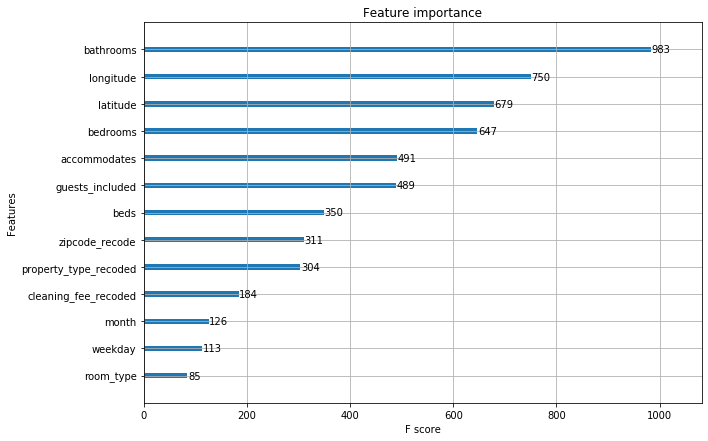

In [74]:
plt.rcParams["figure.figsize"] = (10,7)

xgb.plot_importance(model)

In [75]:
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
rmse

260.5109822303426

In [76]:
test_results = pd.DataFrame(data={'True':y_test, 'Predicted':predictions}, columns= ['True','Predicted'] )
test_results.head()

,True,Predicted
1677792,550.0,547.558533
10701801,110.0,108.057320
8261512,40.0,59.843426
6163719,40.0,59.636257
4911406,200.0,260.375580


In [0]:
test_results.to_csv('predictions.csv', index=False)

In [0]:
# test_results = pd.read_csv('test_predictions.csv')

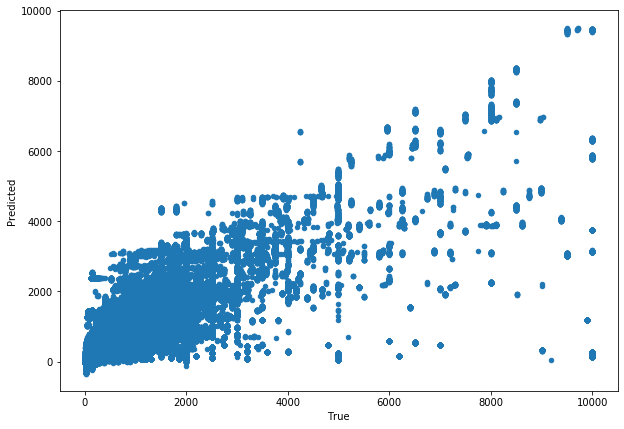

In [77]:
test_results.plot.scatter(x = 'True', y = 'Predicted')

####Save model

In [104]:
# Convert processed data into an xgb.DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [0]:
pickle.dump(model, open("xgbregressor_airbnb_final.dat", "wb"))

In [0]:
# model = pickle.load(open("xgbregressor_airbnb_final.dat", "rb"))

[23:42:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


####Optimize (current model has not been optimized yet)

In [0]:
def xgb_evaluate(colsample_bytree, gamma, learning_rate, max_delta_step, max_depth_step, min_child_weight, n_estimators, subsample):
    params = {'colsample_bytree': colsample_bytree,
              'eta': 0.1,
              'eval_metric': 'rmse',
              'gamma': gamma,
              'learning_rate': learning_rate,
              'max_delta_step': max_delta_step,
              'max_depth_step': int(max_depth_step),
              'min_child_weight': min_child_weight,
              'n_estimators': n_estimators,
              'seed': 9,
              'subsample': subsample}
    # Use around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=1000, nfold=3)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [0]:
xgb_bo = BayesianOptimization(xgb_evaluate, {'colsample_bytree': (0.3, 1),
                                             'gamma': (0, 5),
                                             'learning_rate':(0.01,0.5),
                                             'max_delta_step': (0, 10),
                                             'max_depth_step': (1, 6),
                                             'min_child_weight':(0,5),
                                             'n_estimators':(850, 1200),
                                             'subsample': (0.4, 1.0)})
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=6, n_iter=10, acq='ei')

|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_de... | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------
[22:56:17] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[22:56:24] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[22:56:31] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


KeyboardInterrupt: ignored

In [0]:
# Write our ensemble method - train 11 models, and weight them all equally by finding the mode of the votes for each well.
# The majority vote for each well is the consensus, which will be our predictions
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import random

random.seed(42)
count = 0
score = 0
scores = 0
prediction_votes=pd.DataFrame()
for num in range(1,2):
    seed = random.randint(1,9000)
    model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1, 
                          colsample_bynode=1, colsample_bytree=1, gamma=0,
                          importance_type='gain', learning_rate=0.1, max_delta_step=0,
                          max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
                          n_jobs=-1, nthread=None, objective='reg:squarederror', random_state=0,
                          reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                          silent=None, subsample=1, verbosity=1).fit(X_train, y_train)
    predictions = model.predict(X_val)
    #score = accuracy_score(y_val, predictions)
    prediction_votes[num] = predictions
    scores += score
    count += 1
    print(score)
    y_pred_proba = model.predict_proba(X_train)[:,1]
    print('Test ROC AUC:', roc_auc_score(y_train, y_pred_proba))

print(f"The average accuracy score using these hyperparams over {count} iterations is {scores/count}")

d:\csfiles\lambda\git\airbnb3\airenv\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0


AttributeError: 'XGBRegressor' object has no attribute 'predict_proba'